**Topic:** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;      ***Project Luther***  
**Subject:** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;     ****Trump Tweets vs Stock Market ****  
**Date:**  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;       04/21/2018  
**Name:**   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;      WENDY SANCHEZ-VAYNSHTEYN   

In [116]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import scipy.stats as stats

In [2]:
pd.set_option('display.max_rows',50)

# Trump Tweet Data 

In [3]:
# reading from list of files and merging it into one dataframe
def getData(data):
    merged_dfs = []    
    for i in data:
        print(i)
        file = pd.read_json(i)
        merged_dfs.append(file)
    return pd.concat(merged_dfs, ignore_index = True)

In [4]:
# importing Trumps tweets from 1/1/2017 to 4/19/2018 
data = ['masterttweets_2017.json', 'masterttweets_2018.json']
df = getData(data)


masterttweets_2017.json
masterttweets_2018.json


In [5]:
df.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'is_retweet', 'lang', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'retweet_count',
       'retweeted', 'retweeted_status', 'source', 'text', 'truncated', 'user'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3254 entries, 0 to 3253
Data columns (total 32 columns):
contributors                 0 non-null float64
coordinates                  0 non-null float64
created_at                   3254 non-null datetime64[ns]
display_text_range           1554 non-null object
entities                     2605 non-null object
extended_entities            497 non-null object
favorite_count               3254 non-null int64
favorited                    2605 non-null object
full_text                    1554 non-null object
geo                          0 non-null float64
id                           2605 non-null float64
id_str                       3254 non-null int64
in_reply_to_screen_name      46 non-null object
in_reply_to_status_id        45 non-null float64
in_reply_to_status_id_str    45 non-null float64
in_reply_to_user_id          46 non-null float64
in_reply_to_user_id_str      64 non-null float64
is_quote_status              2605 non-null object

In [7]:
# text and full_text columns have switched at some point yielding NaN's. Merging them will solve the problem.
df['text'].fillna(df.full_text, inplace = True)


In [8]:
#analyzing text
df.loc[: , 'text']

0       Will be leaving Florida for Washington (D.C.) ...
1       Iran is failing at every level despite the ter...
2       The United States has foolishly given Pakistan...
3       HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...
4       As our Country rapidly grows stronger and smar...
5       Iran, the Number One State of Sponsored Terror...
6       What a year it’s been, and we're just getting ...
7       My deepest condolences to the victims of the t...
8       Why would smart voters want to put Democrats i...
9       If the Dems (Crooked Hillary) got elected, you...
10      Big protests in Iran. The people are finally g...
11      “Trump Rally: Stocks put 2017 in the record bo...
12      Jobs are kicking in and companies are coming b...
13      I use Social Media not because I like to, but ...
14      On Taxes: “This is the biggest corporate rate ...
15      Oppressive regimes cannot endure forever, and ...
16      The entire world understands that the good peo...
17      Many r

### TextBlob analysis

In [9]:
# importing textBlob for sentiment analysis
from textblob import TextBlob

In [10]:
# making new column sentiment with sentiment values from textBlob
# The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
df['sentiment'] = df['text'].map(lambda a: TextBlob(str(a)).sentiment)
df['polarity'] = df['text'].map(lambda a: TextBlob(str(a)).polarity)
df['subjectivity'] = df['text'].map(lambda a: TextBlob(str(a)).sentiment.subjectivity)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3254 entries, 0 to 3253
Data columns (total 35 columns):
contributors                 0 non-null float64
coordinates                  0 non-null float64
created_at                   3254 non-null datetime64[ns]
display_text_range           1554 non-null object
entities                     2605 non-null object
extended_entities            497 non-null object
favorite_count               3254 non-null int64
favorited                    2605 non-null object
full_text                    1554 non-null object
geo                          0 non-null float64
id                           2605 non-null float64
id_str                       3254 non-null int64
in_reply_to_screen_name      46 non-null object
in_reply_to_status_id        45 non-null float64
in_reply_to_status_id_str    45 non-null float64
in_reply_to_user_id          46 non-null float64
in_reply_to_user_id_str      64 non-null float64
is_quote_status              2605 non-null object

#### Using Vader to get compound score for tweets

In [11]:
analyzer = SentimentIntensityAnalyzer()
df['compound'] = df['text'].apply(lambda a: analyzer.polarity_scores(a)['compound'])
df.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,retweeted,retweeted_status,source,text,truncated,user,sentiment,polarity,subjectivity,compound
0,NaN,NaN,2018-01-01 13:37:52,"[0, 119]","{'symbols': [], 'user_mentions': [], 'hashtags...",NaN,51473,False,Will be leaving Florida for Washington (D.C.) ...,NaN,...,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Will be leaving Florida for Washington (D.C.) ...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.39015151515151514, 0.4681818181818182)",0.390152,0.468182,0.7871
1,NaN,NaN,2018-01-01 12:44:40,"[0, 283]","{'symbols': [], 'user_mentions': [], 'hashtags...",NaN,53557,False,Iran is failing at every level despite the ter...,NaN,...,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Iran is failing at every level despite the ter...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.07500000000000001, 0.5875)",0.075000,0.587500,0.8672
2,NaN,NaN,2018-01-01 12:12:00,"[0, 284]","{'symbols': [], 'user_mentions': [], 'hashtags...",NaN,138808,False,The United States has foolishly given Pakistan...,NaN,...,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",The United States has foolishly given Pakistan...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.1, 0.4133333333333333)",0.100000,0.413333,-0.8256
3,NaN,NaN,2017-12-31 23:43:04,"[0, 96]","{'symbols': [], 'user_mentions': [], 'hashtags...",NaN,154769,False,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,NaN,...,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.3940909090909091, 0.6809090909090909)",0.394091,0.680909,0.8968
4,NaN,NaN,2017-12-31 22:18:20,"[0, 227]","{'symbols': [], 'user_mentions': [], 'hashtags...",NaN,157655,False,As our Country rapidly grows stronger and smar...,NaN,...,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",As our Country rapidly grows stronger and smar...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.25772727272727275, 0.7257575757575757)",0.257727,0.725758,0.8915


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3254 entries, 0 to 3253
Data columns (total 36 columns):
contributors                 0 non-null float64
coordinates                  0 non-null float64
created_at                   3254 non-null datetime64[ns]
display_text_range           1554 non-null object
entities                     2605 non-null object
extended_entities            497 non-null object
favorite_count               3254 non-null int64
favorited                    2605 non-null object
full_text                    1554 non-null object
geo                          0 non-null float64
id                           2605 non-null float64
id_str                       3254 non-null int64
in_reply_to_screen_name      46 non-null object
in_reply_to_status_id        45 non-null float64
in_reply_to_status_id_str    45 non-null float64
in_reply_to_user_id          46 non-null float64
in_reply_to_user_id_str      64 non-null float64
is_quote_status              2605 non-null object

In [13]:
# new dataframe with  columns of interest.
d1 = df[['created_at', 'display_text_range','entities', 'extended_entities', 'favorite_count', 'favorited','full_text', 'id', 'id_str', 'in_reply_to_screen_name','in_reply_to_status_id', 'in_reply_to_status_id_str','in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status','is_retweet', 'lang', 'possibly_sensitive', 'retweet_count','retweeted', 'retweeted_status', 'source', 'text', 'truncated', 'user','sentiment', 'polarity', 'subjectivity', 'compound']]

In [14]:
d1 = d1.sort_values("created_at")

In [15]:
# if hour is after 4pm when Dow Jones closes, shift date to next day and record this date in new column adjusted_date
d1['adjusted_date']= [x + datetime.timedelta(days=1) if x.hour > 16 else x for x in d1['created_at']] 
d1

,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,id,id_str,in_reply_to_screen_name,...,retweeted_status,source,text,truncated,user,sentiment,polarity,subjectivity,compound,adjusted_date
2604,2017-01-01 05:00:10,NaN,"{'symbols': [], 'user_mentions': [], 'hashtags...",NaN,126230,False,NaN,8.154223e+17,815422340540547072,None,...,NaN,"<a href=""http://twitter.com/download/iphone"" r...",TO ALL AMERICANS-\n#HappyNewYear &amp; many bl...,True,"{'follow_request_sent': False, 'has_extended_p...","(0.8125, 0.75)",0.812500,0.750000,0.8908,2017-01-01 05:00:10
2603,2017-01-01 05:39:13,NaN,"{'symbols': [], 'user_mentions': [{'indices': ...",NaN,0,False,NaN,8.154322e+17,815432169464197120,None,...,"{'contributors': None, 'quoted_status_id': 815...","<a href=""http://twitter.com/download/iphone"" r...",RT @DanScavino: On behalf of our next #POTUS &...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.0, 0.0)",0.000000,0.000000,0.0000,2017-01-01 05:39:13
2602,2017-01-01 05:43:23,NaN,"{'symbols': [], 'user_mentions': [{'indices': ...",NaN,0,False,NaN,8.154332e+17,815433217595547648,None,...,"{'contributors': None, 'truncated': False, 'te...","<a href=""http://twitter.com/download/iphone"" r...",RT @Reince: Happy New Year + God's blessings t...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.6454545454545455, 0.7848484848484848)",0.645455,0.784848,0.8172,2017-01-01 05:43:23
2601,2017-01-01 05:44:17,NaN,"{'symbols': [], 'user_mentions': [{'indices': ...",NaN,0,False,NaN,8.154334e+17,815433444591304704,None,...,"{'contributors': None, 'truncated': False, 'te...","<a href=""http://twitter.com/download/iphone"" r...",RT @EricTrump: 2016 was such an incredible yea...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.475, 0.705)",0.475000,0.705000,0.8118,2017-01-01 05:44:17
2600,2017-01-01 06:49:33,NaN,"{'symbols': [], 'media': [{'source_user_id': 3...","{'media': [{'source_user_id': 39344374, 'sourc...",0,False,NaN,8.154499e+17,815449868739211264,None,...,"{'contributors': None, 'truncated': False, 'te...","<a href=""http://twitter.com/download/iphone"" r...",RT @DonaldJTrumpJr: Happy new year everyone. #...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.4681818181818182, 0.7272727272727273)",0.468182,0.727273,0.5719,2017-01-01 06:49:33
2599,2017-01-01 06:49:49,NaN,"{'symbols': [], 'user_mentions': [{'indices': ...",NaN,0,False,NaN,8.154499e+17,815449933453127680,None,...,"{'contributors': None, 'truncated': True, 'tex...","<a href=""http://twitter.com/download/iphone"" r...",RT @IvankaTrump: 2016 has been one of the most...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.5800000000000001, 0.62)",0.580000,0.620000,0.9765,2017-01-01 06:49:49
2598,2017-01-02 14:40:10,NaN,"{'symbols': [], 'user_mentions': [], 'hashtags...",NaN,124024,False,NaN,8.159307e+17,815930688889352192,None,...,NaN,"<a href=""http://twitter.com/download/android"" ...","Well, the New Year begins. We will, together, ...",False,"{'follow_request_sent': False, 'has_extended_p...","(0.5681818181818181, 0.6022727272727273)",0.568182,0.602273,0.8034,2017-01-02 14:40:10
2597,2017-01-02 17:31:17,NaN,"{'symbols': [], 'user_mentions': [], 'hashtags...",NaN,63340,False,NaN,8.159738e+17,815973752785793024,None,...,NaN,"<a href=""http://twitter.com/download/android"" ...","Chicago murder rate is record setting - 4,331 ...",False,"{'follow_request_sent': False, 'has_extended_p...","(0.0, 0.0)",0.000000,0.000000,-0.8622,2017-01-03 17:31:17
2596,2017-01-02 18:32:29,NaN,"{'symbols': [], 'user_mentions': [{'indices': ...",NaN,13862,False,NaN,8.159892e+17,815989154555297792,CNN,...,NaN,"<a href=""http://twitter.com/download/android"" ...","@CNN just released a book called ""Unprecedente...",False,"{'follow_request_sent': False, 'has_extended_p...","(-0.2, 0.95)",-0.200000,0.950000,-0.6643,2017-01-03 18:32:29
2595,2017-01-02 18:37:10,NaN,"{'symbols': [], 'user_mentions': [], 'hashtags...",N

In [16]:
# added new column 'day' that displays the day (0-6) of the week to be able to spot weekends
#d1['day']= [x.strftime('%A') for x in d1['adjusted_date']]

d1['day']= d1['adjusted_date'].dt.dayofweek
d1.head(5)

,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,id,id_str,in_reply_to_screen_name,...,source,text,truncated,user,sentiment,polarity,subjectivity,compound,adjusted_date,day
2604,2017-01-01 05:00:10,NaN,"{'symbols': [], 'user_mentions': [], 'hashtags...",NaN,126230,False,NaN,8.154223e+17,815422340540547072,None,...,"<a href=""http://twitter.com/download/iphone"" r...",TO ALL AMERICANS-\n#HappyNewYear &amp; many bl...,True,"{'follow_request_sent': False, 'has_extended_p...","(0.8125, 0.75)",0.812500,0.750000,0.8908,2017-01-01 05:00:10,6
2603,2017-01-01 05:39:13,NaN,"{'symbols': [], 'user_mentions': [{'indices': ...",NaN,0,False,NaN,8.154322e+17,815432169464197120,None,...,"<a href=""http://twitter.com/download/iphone"" r...",RT @DanScavino: On behalf of our next #POTUS &...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.0, 0.0)",0.000000,0.000000,0.0000,2017-01-01 05:39:13,6
2602,2017-01-01 05:43:23,NaN,"{'symbols': [], 'user_mentions': [{'indices': ...",NaN,0,False,NaN,8.154332e+17,815433217595547648,None,...,"<a href=""http://twitter.com/download/iphone"" r...",RT @Reince: Happy New Year + God's blessings t...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.6454545454545455, 0.7848484848484848)",0.645455,0.784848,0.8172,2017-01-01 05:43:23,6
2601,2017-01-01 05:44:17,NaN,"{'symbols': [], 'user_mentions': [{'indices': ...",NaN,0,False,NaN,8.154334e+17,815433444591304704,None,...,"<a href=""http://twitter.com/download/iphone"" r...",RT @EricTrump: 2016 was such an incredible yea...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.475, 0.705)",0.475000,0.705000,0.8118,2017-01-01 05:44:17,6
2600,2017-01-01 06:49:33,NaN,"{'symbols': [], 'media': [{'source_user_id': 3...","{'media': [{'source_user_id': 39344374, 'sourc...",0,False,NaN,8.154499e+17,815449868739211264,None,...,"<a href=""http://twitter.com/download/iphone"" r...",RT @DonaldJTrumpJr: Happy new year everyone. #...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.4681818181818182, 0.7272727272727273)",0.468182,0.727273,0.5719,2017-01-01 06:49:33,6


#### Adjusting dates for tweets to count towards correct end of day Dow Jones Index

In [18]:
def adjust_weekend(d):
    if d.dayofweek == 5:
        return d + datetime.timedelta(days=2)
    elif d.dayofweek == 6:
        return d + datetime.timedelta(days=1)
    return d

In [20]:
# adjust weekend days to mondays for next business day of Down Jones

# d1['adjusted_date3'] = [d if d.dayofweek != 5 else d + datetime.timedelta(days=2) for d in d1['adjusted_date']]
d1['adjusted_date2'] = d1['adjusted_date'].apply(adjust_weekend)
  
#d1[(d1['day'] == 5) | (d1['day'] == 6)]

In [21]:
d1['date'] = d1['adjusted_date2'].dt.date
d1.head(5)

,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,id,id_str,in_reply_to_screen_name,...,truncated,user,sentiment,polarity,subjectivity,compound,adjusted_date,day,adjusted_date2,date
2604,2017-01-01 05:00:10,NaN,"{'symbols': [], 'user_mentions': [], 'hashtags...",NaN,126230,False,NaN,8.154223e+17,815422340540547072,None,...,True,"{'follow_request_sent': False, 'has_extended_p...","(0.8125, 0.75)",0.812500,0.750000,0.8908,2017-01-01 05:00:10,6,2017-01-02 05:00:10,2017-01-02
2603,2017-01-01 05:39:13,NaN,"{'symbols': [], 'user_mentions': [{'indices': ...",NaN,0,False,NaN,8.154322e+17,815432169464197120,None,...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.0, 0.0)",0.000000,0.000000,0.0000,2017-01-01 05:39:13,6,2017-01-02 05:39:13,2017-01-02
2602,2017-01-01 05:43:23,NaN,"{'symbols': [], 'user_mentions': [{'indices': ...",NaN,0,False,NaN,8.154332e+17,815433217595547648,None,...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.6454545454545455, 0.7848484848484848)",0.645455,0.784848,0.8172,2017-01-01 05:43:23,6,2017-01-02 05:43:23,2017-01-02
2601,2017-01-01 05:44:17,NaN,"{'symbols': [], 'user_mentions': [{'indices': ...",NaN,0,False,NaN,8.154334e+17,815433444591304704,None,...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.475, 0.705)",0.475000,0.705000,0.8118,2017-01-01 05:44:17,6,2017-01-02 05:44:17,2017-01-02
2600,2017-01-01 06:49:33,NaN,"{'symbols': [], 'media': [{'source_user_id': 3...","{'media': [{'source_user_id': 39344374, 'sourc...",0,False,NaN,8.154499e+17,815449868739211264,None,...,False,"{'follow_request_sent': False, 'has_extended_p...","(0.4681818181818182, 0.7272727272727273)",0.468182,0.727273,0.5719,2017-01-01 06:49:33,6,2017-01-02 06:49:33,2017-01-02


#### checking different sources of tweets

In [22]:
d1.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       'Twitter for iPhone', 'Twitter Web Client', 'Media Studio',
       'Twitter for iPad'], dtype=object)

In [23]:
# checking sources and renaming them 
d1.loc[(d1.source=='<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'), 'source'] = 'Twitter for Android' 

In [24]:
# renaming sources from link 
d1.loc[(d1.source== '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>'), 'source'] = 'Twitter Ads'

In [25]:
d1.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       'Twitter for Android',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       'Twitter Ads',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       'Twitter for iPhone', 'Twitter Web Client', 'Media Studio',
       'Twitter for iPad'], dtype=object)

In [27]:
# tweets from Twitter_WebClient
Twitter_WebClient = d1[d1.source=='Twitter Web Client'][['created_at','text','polarity', 'subjectivity','compound']]
Twitter_WebClient

,created_at,text,polarity,subjectivity,compound
3235,2018-01-11 15:37:54,"Great news, as a result of our TAX CUTS &amp; ...",1.000000,0.7500,0.3525
2673,2018-04-12 18:32:30,Thank you to all of the American workers who t...,0.325000,0.3375,0.9676
2672,2018-04-12 19:03:57,America’s greatest treasure is our people – an...,0.166667,0.1875,0.8939


In [29]:
# tweets Twitter_Ads
Twitter_Ads = d1[d1.source=='Twitter Ads'][['created_at','text','polarity', 'subjectivity','compound']]
Twitter_Ads.head()

,created_at,text,polarity,subjectivity,compound
2092,2017-03-31 18:30:38,It is an exciting time for our country!\n#Week...,0.375000,0.800000,0.5411
2090,2017-03-31 21:31:44,We are going to defend our industry &amp; crea...,0.000000,0.000000,0.4404
2068,2017-04-04 19:38:59,Thank you Sean McGarvey &amp; the entire Gover...,0.000000,0.625000,0.7506
2066,2017-04-05 21:18:08,I am deeply committed to preserving our strong...,0.216667,0.566667,0.8908
2054,2017-04-10 21:59:10,Congratulations to Justice Neil Gorsuch on his...,0.800000,0.750000,0.9571


In [30]:
# Twitter_Android
Twitter_Android = d1[d1.source=='Twitter for Android'][['text','subjectivity', 'polarity','compound']]
Twitter_Android.head()

,text,subjectivity,polarity,compound
2598,"Well, the New Year begins. We will, together, ...",0.602273,0.568182,0.8034
2597,"Chicago murder rate is record setting - 4,331 ...",0.000000,0.000000,-0.8622
2596,"@CNN just released a book called ""Unprecedente...",0.950000,-0.200000,-0.6643
2595,Various media outlets and pundits say that I t...,0.488889,-0.166667,-0.7003
2594,"I thought and felt I would win big, easily ove...",0.558333,0.483333,0.6369


In [104]:
# tweets Twitter_iPad
Twitter_iPad = d1[d1.source=='Twitter for iPad'][['text','subjectivity', 'polarity','compound']]
Twitter_iPad.head()

,text,subjectivity,polarity,compound
3100,With 3.5 million Americans receiving bonuses o...,0.329242,0.202273,0.8252
3099,“Trump the orator outlines the greatness of Am...,0.000000,0.000000,0.0000
3098,"Today, it was my honor to join the great men a...",0.425000,0.350000,0.8591
3069,Our founders invoked our Creator four times in...,0.000000,0.000000,0.4278
3067,As long as we open our eyes to God’s grace - a...,0.642857,0.292857,0.9287


In [105]:
# tweets Twitter_Media
Twitter_Media = d1[d1.source=='Media Studio'][['text','subjectivity', 'polarity','compound']]
Twitter_Media.head()

,text,subjectivity,polarity,compound
3234,"Yesterday, I signed the #INTERDICTAct (H.R. 21...",0.400000,-0.250000,0.6696
3180,"Today, we witnessed an incredible moment in hi...",0.516667,0.416667,0.9265
3127,It was my great honor to welcome Mayor’s from ...,0.511869,0.517298,0.9738
3078,"Today, we heard the experiences of law enforce...",0.000000,0.000000,-0.8316
3073,Best wishes to the Republic of Korea on hostin...,0.683333,1.000000,0.9666


In [31]:
# tweets Twitter_iPhone
Twitter_iPhone = d1[d1.source=='Twitter for iPhone'][['text','subjectivity', 'polarity','compound']]
Twitter_iPhone.head()

,text,subjectivity,polarity,compound
3253,"Today, it was my great honor to sign a new Exe...",0.488636,0.351278,0.9774
3252,"RT @Scavino45: “Utilities cutting rates, cite ...",0.900000,-0.600000,0.2732
3251,"As I made very clear today, our country needs ...",0.249167,0.065000,0.8122
3250,Thank you @GOPLeader Kevin McCarthy! Couldn’t ...,0.500000,0.500000,0.6476
3249,".@ICEgov HSI agents and ERO officers, on behal...",0.375000,0.208333,0.9006


In [32]:
d1.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       'Twitter for Android',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       'Twitter Ads',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       'Twitter for iPhone', 'Twitter Web Client', 'Media Studio',
       'Twitter for iPad'], dtype=object)

In [32]:
# tweet_df ready for merging with average polarity and subjectivity per day

tweet_df = d1.groupby('date')['date','polarity','subjectivity', 'compound'].mean().reset_index()
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 4 columns):
date            328 non-null object
polarity        328 non-null float64
subjectivity    328 non-null float64
compound        328 non-null float64
dtypes: float64(3), object(1)
memory usage: 10.3+ KB


# Dow Jones Data 

In [34]:
# importing DJIA from last week of 2016 to 4/20/18
DJ = pd.read_csv('DJIA.csv')
DJ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 2 columns):
DATE    343 non-null object
DJIA    343 non-null object
dtypes: object(2)
memory usage: 5.4+ KB


In [35]:
# getting rid of holidays (denoted by ".")
# DJ = DJ[DJ['DJIA'] != '.']
DJ['DJIA'] = DJ['DJIA'].apply(lambda x: float(x.replace('.','0')))

In [36]:
# changed type of date from string to dateformat and dropped old column for typing convenience of label 
DJ['DATE']= pd.to_datetime(DJ['DATE'], infer_datetime_format=True)
DJ.head()

,DATE,DJIA
0,2016-12-27,19945004.0
1,2016-12-28,19833068.0
2,2016-12-29,19819078.0
3,2016-12-30,19762060.0
4,2017-01-02,0.0


In [37]:
# rename DATE column to date in order to be able to merge 

DJ = DJ.rename(index=str, columns={"DATE":"date" })


In [38]:
# convert DJIA to float

DJ['DJIA'] = pd.to_numeric(DJ['DJIA'])
DJ.head()

,date,DJIA
0,2016-12-27,19945004.0
1,2016-12-28,19833068.0
2,2016-12-29,19819078.0
3,2016-12-30,19762060.0
4,2017-01-02,0.0


In [39]:
tweet_df['date']= pd.to_datetime(tweet_df['date'], infer_datetime_format=True)

In [60]:
# created master_df to merge d1 tweets and df DJ index together
master_df= pd.merge(tweet_df, DJ, how='outer', on="date")
master_df.head(5)

,date,polarity,subjectivity,compound,DJIA
0,2017-01-02,0.507045,0.598485,0.695943,0.0
1,2017-01-03,-0.037153,0.564525,-0.053550,19881076.0
2,2017-01-04,-0.039706,0.516291,-0.102392,19942016.0
3,2017-01-05,-0.072639,0.391647,-0.048750,19899029.0
4,2017-01-06,0.116547,0.309958,0.340042,19963080.0


In [65]:
# for dates that are holidays and have a '.' in the DJIA cell, switch date to next dat in order to correlate to tweets of same day.
master_df.loc[master_df.DJIA == 0, ['date']] = master_df.loc[master_df.DJIA == 0, ['date']] + datetime.timedelta(days=1)


In [66]:
master_df.head()

,date,subjectivity,polarity,compound,DJIA
0,2016-12-27 00:00:00,NaN,NaN,NaN,19945004.0
1,2016-12-28 00:00:00,NaN,NaN,NaN,19833068.0
2,2016-12-29 00:00:00,NaN,NaN,NaN,19819078.0
3,2016-12-30 00:00:00,NaN,NaN,NaN,19762060.0
4,2017-01-03 00:00:00,0.581505,0.234946,0.321196,19881076.0


In [69]:
# data engineering of each column to give average and sum based on dates and columns
master_df = master_df.groupby(['date'], as_index= False).agg({'subjectivity':'mean','polarity': 'mean' ,'compound':'mean', 'DJIA':'sum'})
master_df.head()

,date,subjectivity,polarity,compound,DJIA
0,2016-12-27,NaN,NaN,NaN,19945004.0
1,2016-12-28,NaN,NaN,NaN,19833068.0
2,2016-12-29,NaN,NaN,NaN,19819078.0
3,2016-12-30,NaN,NaN,NaN,19762060.0
4,2017-01-03,0.581505,0.234946,0.321196,19881076.0


In [117]:
#dropping days that have Nans
data_df = master_df.dropna(how='any')
data_df() 

TypeError: 'DataFrame' object is not callable

In [71]:
# dropped two data points that accounted for DJIA == 0
data_df = data_df[data_df["DJIA"]!=0]
data_df.head()

,date,subjectivity,polarity,compound,DJIA
4,2017-01-03,0.581505,0.234946,0.321196,19881076.0
5,2017-01-04,0.516291,-0.039706,-0.102392,19942016.0
6,2017-01-05,0.391647,-0.072639,-0.048750,19899029.0
7,2017-01-06,0.309958,0.116547,0.340042,19963080.0
8,2017-01-09,0.606703,0.183877,0.119800,19887038.0


### Trump Approval ratings

In [72]:
# trump approval ratings https://projects.fivethirtyeight.com/trump-approval-ratings/
approval = pd.read_csv('approval_topline.csv')
approval.head()

,president,subgroup,modeldate,approve_estimate,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo,timestamp
0,Donald Trump,Voters,4/26/2018,42.09647,46.43002,37.76293,53.20510,56.60579,49.80441,09:36:54 26 Apr 2018
1,Donald Trump,Adults,4/26/2018,39.29548,42.77197,35.81899,54.25216,58.77565,49.72866,09:36:43 26 Apr 2018
2,Donald Trump,All polls,4/26/2018,40.50186,45.10455,35.89917,53.70563,57.83012,49.58114,09:36:31 26 Apr 2018
3,Donald Trump,Voters,4/25/2018,42.11814,46.45359,37.78269,53.15680,56.61290,49.70070,18:19:53 25 Apr 2018
4,Donald Trump,Adults,4/25/2018,39.29548,42.77197,35.81899,54.25216,58.77565,49.72866,18:19:42 25 Apr 2018


In [73]:
#selecting columns of interest
approval = approval[approval.subgroup == 'All polls']
approval = approval.sort_values(['modeldate'])[['modeldate','approve_estimate', 'disapprove_estimate']]

In [74]:
approval['date']=pd.to_datetime(approval.modeldate,infer_datetime_format=True)
approval.head()

,modeldate,approve_estimate,disapprove_estimate,date
347,1/1/2018,37.86540,56.16106,2018-01-01
320,1/10/2018,39.22063,54.60398,2018-01-10
317,1/11/2018,39.10347,54.63946,2018-01-11
314,1/12/2018,39.10097,54.52315,2018-01-12
310,1/13/2018,39.10097,54.52315,2018-01-13


In [75]:
approval = approval.sort_values(by='date')[['date','approve_estimate', 'disapprove_estimate']]
approval.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459 entries, 1374 to 2
Data columns (total 3 columns):
date                   459 non-null datetime64[ns]
approve_estimate       459 non-null float64
disapprove_estimate    459 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 14.3 KB


In [76]:
#merging approval dataframe to that of tweets with Dow Jones 
new_df = approval.merge(data_df, on= 'date')

In [77]:
# checking correlations on new dataframe
new_df.corr()

,approve_estimate,disapprove_estimate,subjectivity,polarity,compound,DJIA
approve_estimate,1.000000,-0.925267,0.023462,-0.134018,-0.109151,-0.417032
disapprove_estimate,-0.925267,1.000000,-0.015377,0.146392,0.121464,0.466017
subjectivity,0.023462,-0.015377,1.000000,0.331253,0.117121,0.132297
polarity,-0.134018,0.146392,0.331253,1.000000,0.686886,0.087060
compound,-0.109151,0.121464,0.117121,0.686886,1.000000,0.124390
DJIA,-0.417032,0.466017,0.132297,0.087060,0.124390,1.000000


In [78]:
# approval estimate is redundant
new_df.drop('approve_estimate', axis=1,inplace=True )

In [98]:
new_df.head()

,date,disapprove_estimate,subjectivity,polarity,compound,DJIA,prev,prev1,prev2,prev3,prev4
0,2017-01-23,41.26452,0.315691,0.137860,0.218200,19799085.0,NaN,NaN,NaN,NaN,NaN
1,2017-01-24,41.87849,0.238636,0.167614,0.379050,19912071.0,19799085.0,NaN,NaN,NaN,NaN
2,2017-01-25,42.52911,0.463915,0.055952,0.125544,20068051.0,19912071.0,19799085.0,NaN,NaN,NaN
3,2017-01-26,41.06081,0.490104,0.025000,-0.105962,20100091.0,20068051.0,19912071.0,19799085.0,NaN,NaN
4,2017-01-27,41.67268,0.462753,0.194602,0.311975,20093078.0,20100091.0,20068051.0,19912071.0,19799085.0,NaN


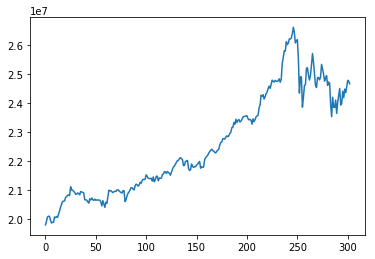

In [80]:
#checking DJIA 
new_df.DJIA.plot()

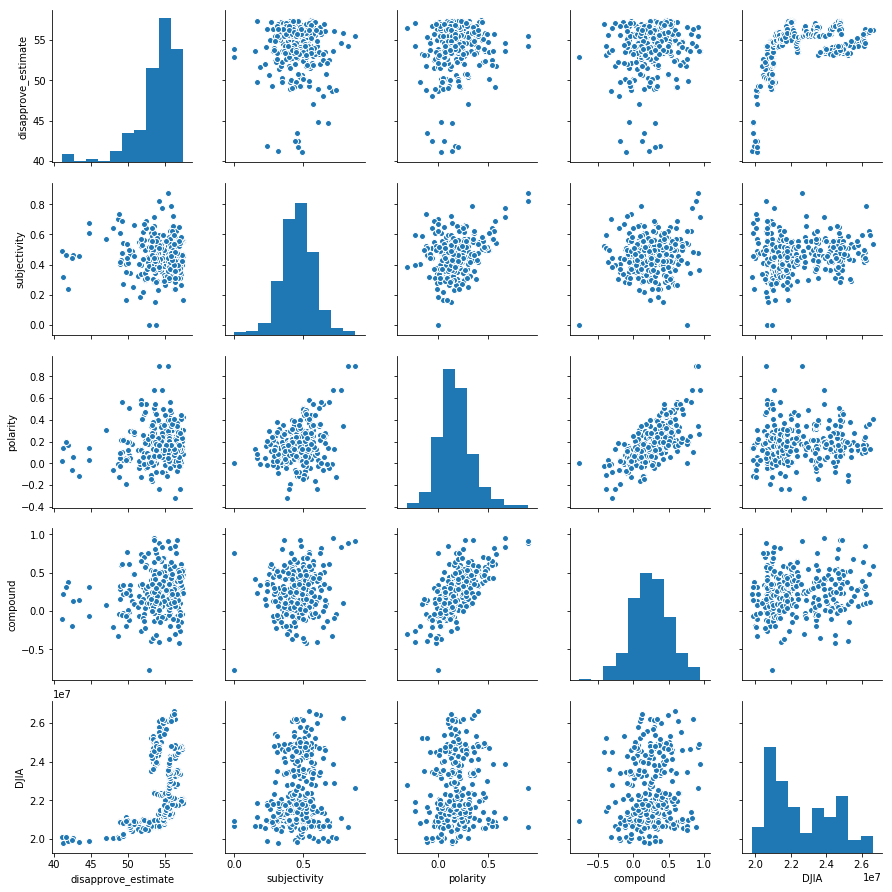

In [81]:
#chceking correlations
sns_plot=sns.pairplot(new_df)
sns_plot.savefig("output.png")

In [92]:
#creating time series
new_df['prev']=new_df.DJIA.shift()

In [93]:
new_df['prev1']=new_df.prev.shift()


In [94]:
new_df['prev2'] = new_df.prev1.shift()

In [95]:
new_df['prev3'] = new_df.prev2.shift()

In [96]:
new_df['prev4'] = new_df.prev3.shift()

In [99]:
obi_df = new_df

In [100]:
obi_df.head()

,date,disapprove_estimate,subjectivity,polarity,compound,DJIA,prev,prev1,prev2,prev3,prev4
0,2017-01-23,41.26452,0.315691,0.137860,0.218200,19799085.0,NaN,NaN,NaN,NaN,NaN
1,2017-01-24,41.87849,0.238636,0.167614,0.379050,19912071.0,19799085.0,NaN,NaN,NaN,NaN
2,2017-01-25,42.52911,0.463915,0.055952,0.125544,20068051.0,19912071.0,19799085.0,NaN,NaN,NaN
3,2017-01-26,41.06081,0.490104,0.025000,-0.105962,20100091.0,20068051.0,19912071.0,19799085.0,NaN,NaN
4,2017-01-27,41.67268,0.462753,0.194602,0.311975,20093078.0,20100091.0,20068051.0,19912071.0,19799085.0,NaN


In [105]:
from sklearn import model_selection
model = LinearRegression(normalize=True)
X = obi_df.dropna().drop(["DJIA", "date"],1)
y = obi_df.dropna()["DJIA"]
obi_df["one"]=np.ones(len(obi_df))
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

#### Modeling 

In [106]:
#training
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, shuffle=False)
# Fit the model against the training data
model = sm.OLS(y_train, X_train)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DJIA   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2606.
Date:                Tue, 01 May 2018   Prob (F-statistic):          1.96e-200
Time:                        14:04:02   Log-Likelihood:                -2666.6
No. Observations:                 208   AIC:                             5353.
Df Residuals:                     198   BIC:                             5387.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
disapprove_estimate  2515.8752   3346.497      0.752      0.453   -4083.475    9115.226
subjectivity         -1.66e+04   5.55e+04     -0.299      0.765   -1.26e+05    9.28e+04
polarity            -1.673e+04   5.72e+04     -0.293      0.770    -1.3e+05    9.61e+04
compound            -1.644e+04   3.46e+04     -0.475      0.635   -8.47e+04    5.18e+04
prev                    0.9494      0.073     12.997      0.000       0.805       1.093
prev1                   0.0434      0.099      0.439      0.661      -0.151       0.238
prev2                   0.0257      0.099      0.259      0.796      -0.169       0.221
prev3                  -0.0924      0.098     -0.940      0.348      -0.286       0.101
prev4                   0.0727      0.072      1.014      0.312      -0.069       0.214
one                  -7.48e+04   1.51e+05     -0.495      0.621   -3.73e+05    2.23e+05
==============================================================================
Omnibus:                       16.576   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.891
Skew:                          -0.291   Prob(JB):                     2.18e-09
Kurtosis:                       5.065   Cond. No.                     1.15e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### test

In [108]:
lr = LinearRegression(fit_intercept=False)  # we don't need intercept, we have 
#scalar.fit(X_train)
lr.fit(X_train,y_train)
# Print out the R^2 for the model against the full dataset
print(lr.score(X_train,y_train))
y_predict = lr.predict(X_test)
print(lr.score(X_test, y_test))
#r2_score(y_test, y_predict)
print(lr.coef_)


0.9916296477785215
0.8032869812458904
[ 2.51587525e+03 -1.66028035e+04 -1.67322457e+04 -1.64364863e+04
  9.49369312e-01  4.33704594e-02  2.56558314e-02 -9.23884435e-02
  7.27329450e-02 -7.47950906e+04]


#### checking actual tweet on test 

In [110]:
fit.predict(X_test).iloc[13]
#fit.predict(X_test).iloc[199]


24795649.73773012

#### residuals

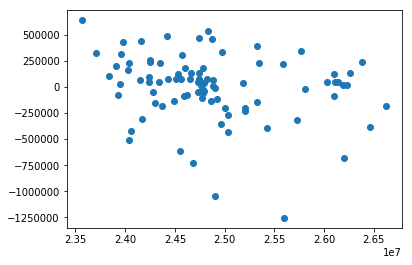

In [122]:
res = y_test - y_predict
plt.scatter(y_predict, res)
plt.show()

#### Q-Q plot

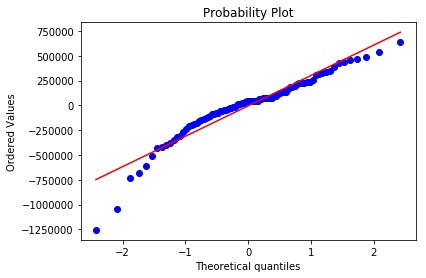

In [121]:
plt.figure()
stats.probplot(res, dist="norm", plot = plt)
plt.show()

In [125]:
# change date to get row of data you want to test against to see prediction vs actual
obi_df[obi_df['date']== '2017-02-09'][['disapprove_estimate','subjectivity','polarity','compound','DJIA', 'prev', 'prev1', 'prev2','prev3','prev4']]

,disapprove_estimate,subjectivity,polarity,compound,DJIA,prev,prev1,prev2,prev3,prev4
13,49.3256,0.540344,0.22293,0.216692,20172040.0,20054034.0,20090029.0,20052042.0,20071046.0,19884091.0


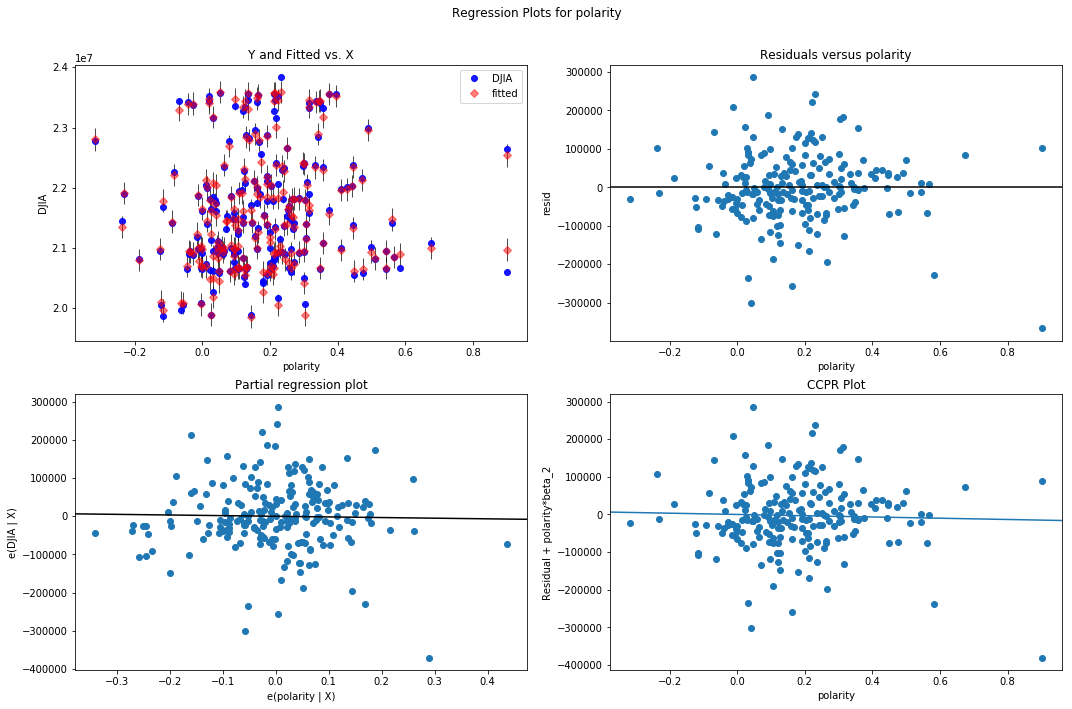

In [127]:
fig = plt.figure(figsize=(15,10))
fig = sm.graphics.plot_regress_exog(fit, 'polarity', fig=fig)

#### Sanity check 

In [128]:
# model without sentiment --- just time series
one_df = obi_df.sort_values(by="date")[['date','DJIA','disapprove_estimate','prev','prev1','prev2','prev3','prev4']]
one_df.head(10)

,date,DJIA,disapprove_estimate,prev,prev1,prev2,prev3,prev4
0,2017-01-23,19799085.0,41.26452,NaN,NaN,NaN,NaN,NaN
1,2017-01-24,19912071.0,41.87849,19799085.0,NaN,NaN,NaN,NaN
2,2017-01-25,20068051.0,42.52911,19912071.0,19799085.0,NaN,NaN,NaN
3,2017-01-26,20100091.0,41.06081,20068051.0,19912071.0,19799085.0,NaN,NaN
4,2017-01-27,20093078.0,41.67268,20100091.0,20068051.0,19912071.0,19799085.0,NaN
5,2017-01-30,19971013.0,42.45613,20093078.0,20100091.0,20068051.0,19912071.0,19799085.0
6,2017-01-31,19864009.0,43.45351,19971013.0,20093078.0,20100091.0,20068051.0,19912071.0
7,2017-02-01,19890094.0,44.69287,19864009.0,19971013.0,20093078.0,20100091.0,20068051.0
8,2017-02-02,19884091.0,44.79839,19890094.0,19864009.0,19971013.0,20093078.0,20100091.0
9,2017-02-03,20071046.0,47.06427,19884091.0,19890094.0,19864009.0,19971013.0,20093078.0


Text(0.5,1,'Correlation of Features')

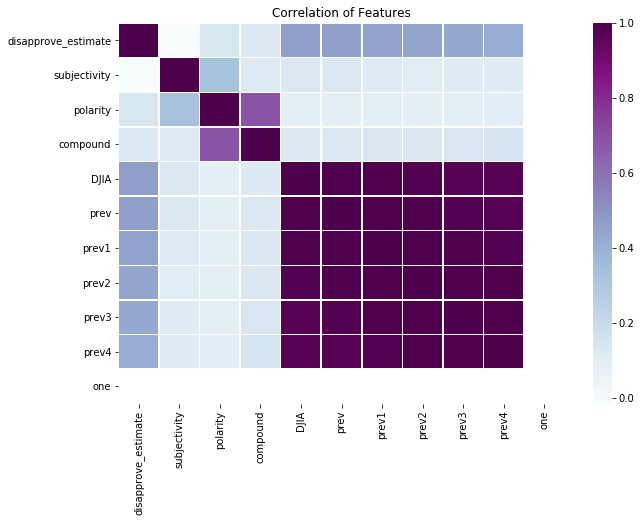

In [129]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10,7))
sns.heatmap(obi_df.corr(), annot=False, linewidths=.5, cmap='BuPu')
plt.title('Correlation of Features')
#lag_time.corr()

In [130]:
from sklearn import model_selection
model = LinearRegression()
X = one_df.dropna().drop(["DJIA", "date"],1)
y = one_df.dropna()["DJIA"]
one_df["one"]=np.ones(len(one_df))
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [131]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, shuffle=False)
# Fit the model against the training data
model = sm.OLS(y_train, X_train)
fit2 = model.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DJIA   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.954e+06
Date:                Tue, 01 May 2018   Prob (F-statistic):               0.00
Time:                        14:14:34   Log-Likelihood:                -2667.5
No. Observations:                 208   AIC:                             5347.
Df Residuals:                     202   BIC:                             5367.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
disapprove_estimate  1951.8463   3147.887      0.620      0.536   -4255.087    8158.779
prev                    0.9383      0.071     13.132      0.000       0.797       1.079
prev1                   0.0534      0.098      0.546      0.585      -0.139       0.246
prev2                   0.0327      0.098      0.335      0.738      -0.160       0.225
prev3                  -0.0993      0.098     -1.018      0.310      -0.292       0.093
prev4                   0.0709      0.071      0.997      0.320      -0.069       0.211
==============================================================================
Omnibus:                       20.929   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.031
Skew:                          -0.365   Prob(JB):                     4.13e-13
Kurtosis:                       5.459   Cond. No.                     2.40e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [132]:

lr = LinearRegression(fit_intercept=False)  # we don't need intercept, we have 
#scalar.fit(X_train)
lr.fit(X_train,y_train)
# Print out the R^2 for the model against the full dataset
print("train", lr.score(X_train,y_train))
y_predict = lr.predict(X_test)
print("cross val", lr.score(X_test, y_test))
#r2_score(y_test, y_predict)
print(lr.coef_)


train 0.99155738598101
cross val 0.8027132243706846
[ 1.95184628e+03  9.38326635e-01  5.33937508e-02  3.26836893e-02
 -9.92894554e-02  7.09238627e-02]


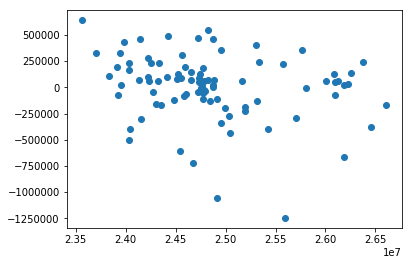

In [133]:
res = y_test - y_predict
plt.scatter(y_predict, res)

In [134]:
fit2.predict(X_test).iloc[13]

24789128.928036906

In [135]:
import scipy.stats as stats

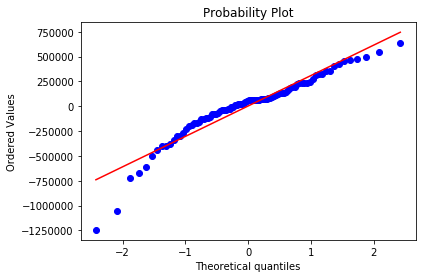

In [137]:
plt.figure()
stats.probplot(res, dist="norm", plot = plt)


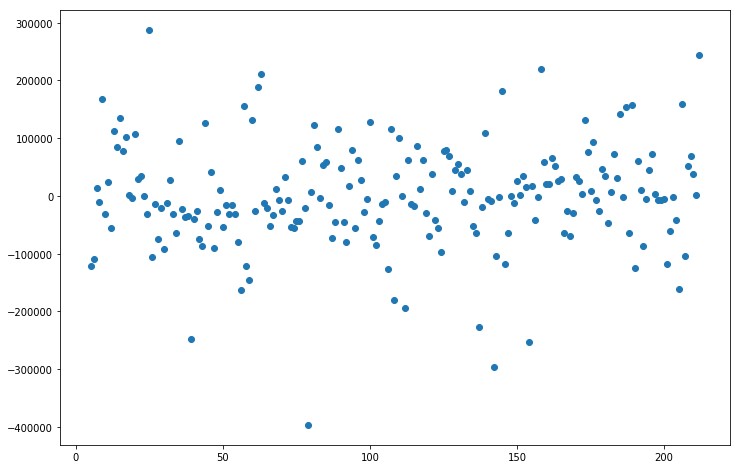

In [138]:
fit2.resid.plot(style='o', figsize=(12,8));

In [141]:
two = obi_df.sort_values(by="date")[['date','DJIA','subjectivity', 'polarity','compound','disapprove_estimate','prev_day','prev1','prev2','prev3','prev4']]

KeyError: "['prev_day'] not in index"

In [85]:
from sklearn import model_selection
model = LinearRegression()
X = two.dropna().drop(["DJIA", "date"],1)
y = two.dropna()["DJIA"]
model.fit(X, y)

NameError: name 'two' is not defined

In [86]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, shuffle=False)
# Fit the model against the training data
model = sm.OLS(y_train, X_train)
fit3 = model.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DJIA   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.954e+06
Date:                Fri, 27 Apr 2018   Prob (F-statistic):               0.00
Time:                        07:35:23   Log-Likelihood:                -2667.5
No. Observations:                 208   AIC:                             5347.
Df Residuals:                     202   BIC:                             5367.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
disapprove_estimate  1951.8463   3147.887      0.620      0.536   -4255.087    8158.779
prev                    0.9383      0.071     13.132      0.000       0.797       1.079
prev1                   0.0534      0.098      0.546      0.585      -0.139       0.246
prev2                   0.0327      0.098      0.335      0.738      -0.160       0.225
prev3                  -0.0993      0.098     -1.018      0.310      -0.292       0.093
prev4                   0.0709      0.071      0.997      0.320      -0.069       0.211
==============================================================================
Omnibus:                       20.929   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.031
Skew:                          -0.365   Prob(JB):                     4.13e-13
Kurtosis:                       5.459   Cond. No.                     2.40e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
fit3.predict(X_test).iloc[13]

In [ ]:
lr = LinearRegression(fit_intercept=False)  # we don't need intercept, we have 
#scalar.fit(X_train)
lr.fit(X_train,y_train)
# Print out the R^2 for the model against the full dataset
print(lr.score(X_train,y_train))
y_predict = lr.predict(X_test)
print(lr.score(X_test, y_test))
#r2_score(y_test, y_predict)
print(lr.coef_)
